# =====================================================================================================
# Plotting of the drifters
# =====================================================================================================

In [1]:
import urllib
import numpy as np
import glob
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import xarray as xr
from timeit import default_timer as timer



In [2]:
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.pad_inches"] = 0.1

## Functions

In [3]:
import plot_functions
from functions.distance import great_circle
plt.style.use(['default'])


def set_ax(ax, lat_extent= [50,90]):
    ax.add_feature(plot_functions.land_50m, facecolor='lightgrey')
    ax.set_extent([-180,180,lat_extent[0],lat_extent[1]],  ccrs.PlateCarree())
    plot_functions.set_circular_boundary(ax)
    ax.gridlines(xlocs = np.arange(-180,185,30), ylocs = np.arange(0,95,5), color='black', alpha=0.5, linestyle=':')
    return ax
def dist(buoy_df, ds_traj):
    '''Finds distances between dataframe buoy and a dataset trajectory
    Return distance array in km'''
    ind     = find_overlap_days(buoy_df, ds_traj)
    ds_traj = ds_traj.isel(obs=ind)
    dist     = great_circle(lon1=buoy_df['lon'], lat1=buoy_df['lat'], lon2=ds_traj['lon'], lat2=ds_traj['lat'])
    return dist/1000

def real_time(ds):
    start_fieldset      = ds.time.units.split('since ')[1]
    ds['real_time']    =  ds.time.astype( dtype='timedelta64[s]') +  np.datetime64(start_fieldset)
    return ds

def find_overlap_days(buoy_df,ds):
    '''
    Finds overlapping days
    Insert dataframe, dataset (only one trajectory)
    Returns indices
    '''
    indices = []
    b_days = buoy_df['dates'].values       #buoy day
    p_days = ds['real_time'].values      #parcels day

    for i in range(len(p_days)):
        p_day = ds['real_time'].values[i]      #parcels day
        if p_day in b_days:
            indices.append(i)
    return indices

In [4]:
def mean_dist(dist_list):
    return np.nanmean(np.array(dist_list), axis = 0)
def std_dist(dist_list):
    return np.nanstd(np.array(dist_list), axis = 0)
def fill_std(x, dist_list):
    mean = mean_dist(dist_list)
    std  = std_dist(dist_list)
    y1   = mean-std
    y2   = mean+std
    return y1, y2


## Initiate drifters

In [5]:
df = pd.read_pickle("output/df_all")
unique_ids = sorted(list(set(df.buoy_id.tolist())))

df_init = pd.read_pickle("output/df_init")
unique_init= sorted(df_init.buoy_id.values)
print " Nr of driter buoys id's is ", len(unique_init)

 Nr of driter buoys id's is  1028


The next cell tries to split the buoy ids based on the regions

Text(0.5,1,'All others\nN other = 253')

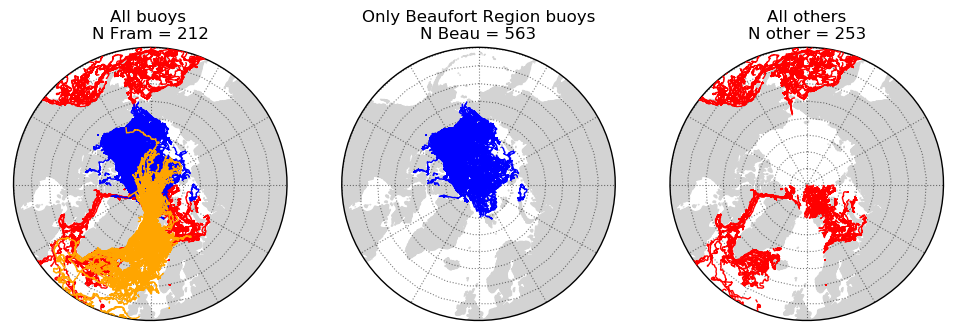

In [6]:
fig = plt.figure(figsize=[12,6])
axf = fig.add_subplot(1,3,1,projection=ccrs.NorthPolarStereo())
axf = set_ax(axf)

axb = fig.add_subplot(1,3,2,projection=ccrs.NorthPolarStereo())
axb = set_ax(axb)

axo = fig.add_subplot(1,3,3,projection=ccrs.NorthPolarStereo())
axo = set_ax(axo)
    
bid_fram = []
bid_beau = []
bid_other = []
for id in unique_ids:
    one_buoy = df.loc[df.buoy_id==id]
    '''FRAM STRAIT'''
    if any((y <80 and y>50) for y in one_buoy.lat.values):      #lats
        if any((x >-20 and x<10)for x in (one_buoy.lon.values)):  #lons
            axf.plot(one_buoy.lon, one_buoy.lat, transform=ccrs.Geodetic(), color = 'orange', zorder=10, linewidth=1)
            bid_fram.append(id)
            continue
    '''Beaufort gyre'''        
    if(max(abs(one_buoy.lon))<90):
        bid_other.append(id)
        axf.plot(one_buoy.lon, one_buoy.lat, transform=ccrs.Geodetic(), color = 'red', zorder =5, linewidth=1)
        axo.plot(one_buoy.lon, one_buoy.lat, transform=ccrs.Geodetic(), color = 'red', zorder =5, linewidth=1)

    else:
        if( min(one_buoy.lat)>65 ): 
            bid_beau.append(id)
            axf.plot(one_buoy.lon, one_buoy.lat, transform=ccrs.Geodetic(), color = 'blue', zorder =9, linewidth=1)
            axb.plot(one_buoy.lon, one_buoy.lat, transform=ccrs.Geodetic(), color = 'blue', zorder =9, linewidth=1)

            
        else: 
            bid_other.append(id)
            axf.plot(one_buoy.lon, one_buoy.lat, transform=ccrs.Geodetic(), color = 'red', zorder =5, linewidth=1)
            axo.plot(one_buoy.lon, one_buoy.lat, transform=ccrs.Geodetic(), color = 'red', zorder =5, linewidth=1)

axf.set_title("All buoys \nN Fram = {}".format(len(bid_fram)))
axb.set_title("Only Beaufort Region buoys\nN Beau = {}".format(len(bid_beau)))
axo.set_title("All others\nN other = {}".format(len(bid_other)))


## Load virtual drifters

In [7]:
colors = ['red', 'blue', 'orange', 'green' , 'purple']
colors = np.tile(colors, len(unique_ids)/4)



In [8]:
files = glob.glob("/scratch/AnnekeV/output/drifters/all/june26/*.nc")

In [9]:
ylim = 600

# Virtual vs observed buoy distance

In [ ]:
def make_distance_plots_virtual_vs_observed(drifter_ids, name='', fig_save=False, plot_map_drift=False, method='median', kernels='both'):
    start = timer()

    ndrifters    = len(drifter_ids)
    ndrifters    = 100
    len_obs      = 3000
    day          = 86400.  #s
    i            = 3 # just take the middle one

    
    new_means    = np.zeros([ndrifters,len_obs])
    old_means    = np.zeros([ndrifters,len_obs])
    new_means[:] = np.nan
    old_means[:] = np.nan
    XX           = np.zeros(len_obs)
    XX[:]        = np.nan
    non_existing = []
    
    fig_distances = plt.figure()
    ax_dist       = fig_distances.add_subplot(1,1,1)
    count         = 0
    X             = [0]
    
    if kernels== 'both':
        sic_label = 'sic'
    else:
        sic_label = ""

    if plot_map_drift:
        fig           = plt.figure(figsize = [6,6])
        ax            = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo())
        ax            = set_ax(ax, lat_extent=[50,90])

    for drifter in drifter_ids:
        try:
            b_ind = np.squeeze(np.where(df['buoy_id'] == drifter))      # extract indices where virtual drifter is equal to buoy

            one_buoy =  df.iloc[b_ind]   # extract the buoy with the right id
            one_buoy =  one_buoy.sort_values(by=['year', 'month', 'day', 'hour'], ascending=True)   # make sure it is sorted
            x        =  (one_buoy['dates'].values-one_buoy['dates'].values[0]).astype('timedelta64[s]')                                                             
            if len(x) > len(X): X = x
            nobs  = len(x)

            '''New and old are respectively the sig and sic kernel (so complicated and simple )'''
            f_d21_new = glob.glob('/scratch/AnnekeV/output/drifters/all/june26/*drifter{}_*new*npart_5*'.format(drifter))
            f_d21_old = glob.glob('/scratch/AnnekeV/output/drifters/all/june26/*drifter{}_*old*npart_5*'.format(drifter))

            if not f_d21_new:
                non_existing.append(drifter)
                continue
            if len(f_d21_new) > 1: print("{} new has multiple files".format(drifter))
            if len(f_d21_old) > 1: print("{} old has multiple files".format(drifter))

            f_d21_new = f_d21_new[0]     
            f_d21_old = f_d21_old[0]     

            '''the corresponding data files'''    
            ds_new = xr.open_dataset(f_d21_new, decode_times=False)
            ds_new = real_time(ds_new)
            npart  = np.size(ds_new.lat,0)

            ds_old = xr.open_dataset(f_d21_old, decode_times=False)
            ds_old = real_time(ds_old)
            npart  == np.size(ds_old.lat,0)

            time = ds_new.real_time
            lats = ds_new.lat

            if plot_map_drift:
                '''Plot the map with the different drifters on it'''
                ax.plot(one_buoy['lon'], one_buoy['lat'], '--', transform=ccrs.Geodetic(), label="buoy 21",  linewidth=.5, color='blue')
                
                if kernels == 'both':
                    ax.plot(ds_new['lon'][i], ds_new['lat'][i], transform=ccrs.Geodetic(), label ='parcels, sig, {}'.format(i), linewidth=.5, color = 'green')
                    ax.plot(ds_old['lon'][i], ds_old['lat'][i],'-.', transform=ccrs.Geodetic(), label =sic_label, linewidth=.5, color = 'red')

    #         print (len(one_buoy)wh)
            '''Initialize distances'''
            dists_new    = np.zeros( len(one_buoy))
            dists_new[:] = np.nan
            dists_old    = np.zeros( len(one_buoy))
            dists_old[:] = np.nan


            difference_intial_date = ds_new.isel(traj=i).real_time.isel(obs=0).values - one_buoy.dates.values[0]
            indices                = np.searchsorted(ds_new.isel(traj=i).real_time.values,   one_buoy.dates.values+difference_intial_date)

            '''Make sure indices match in length'''
            while (indices[-1] >= len(ds_new.lat.isel(traj=0))) or (indices[-1] >= len(dists_new)):
                if len(indices)==1: continue
                indices  = indices[:-1]
            nlen      = len(indices)


            traj_n    = ds_new.isel(traj=i).isel(obs=indices)
            dist_n    = great_circle(one_buoy.lon.values[:nlen], one_buoy.lat.values[:nlen], traj_n.lon.values, traj_n.lat.values)/1000

            traj_o    = ds_old.isel(traj=i).isel(obs=indices)
            dist_o    =  great_circle(one_buoy.lon.values[:nlen], one_buoy.lat.values[:nlen], traj_o.lon.values, traj_o.lat.values)/1000
            dists_new[indices] =  dist_n 
            dists_old[indices] =  dist_o 


            if kernels == 'both':
                ax_dist.plot(x/day, dists_new, color=colors[count], label='sig/new')
                ax_dist.plot(x/day, dists_old, '--', color=colors[count], label=sic_label)
            else:
                ax_dist.plot(x/day, dists_old, '--', color=colors[count], label='Median')


            ax_dist.set_xlabel("Time since start simulation (days)")
            ax_dist.set_ylabel("Mean distance buoy - particles (km)")

            '''For every drifter'''
            new_means[count, indices] = dist_n
            old_means[count, indices] = dist_o
            if new_means.max() <10: print drifter

            count+=1
        except:
            non_existing.append(drifter)
    if plot_map_drift:
        ax.set_title("{} drifters".format(count))

#     fig_mat = plt.figure()
#     ax_mat = fig_mat.add_subplot(1,2,1)
#     ax_mat.matshow(new_means)
#     ax_mat2= fig_mat.add_subplot(1,2,2)
#     ax_mat2.matshow(old_means)
#     print new_means
#     plt.show()

    print("{} non existing buoys".format(len(non_existing)))   
    
    '''combined drifter mean'''
    XX[:len(X)] = X/day
    fig_mean    = plt.figure()
    ax_mean     = fig_mean.add_subplot(1,1,1)
    
    if method == 'mean':
        comb_mean_n = np.nanmean(new_means, axis=0)
        comb_std_n  = np.nanstd(new_means, axis=0)
        low_lim_n, upp_lim_n   = comb_mean_n - comb_std_n, comb_mean_n + comb_std_n
        comb_mean_o = np.nanmean(old_means, axis=0)
        comb_std_o  = np.nanstd(old_means, axis=0)
        low_lim_o, upp_lim_o   = comb_mean_o - comb_std_o, comb_mean_o + comb_std_o
    elif method =='median':
        comb_mean_n = np.nanmedian(new_means, axis=0)
        low_lim_n   = np.nanpercentile(new_means, q=17, axis=0)
        upp_lim_n   = np.nanpercentile(new_means, q=83, axis=0)
        comb_mean_o = np.nanmedian(old_means, axis=0)
        low_lim_o   = np.nanpercentile(old_means, q=17, axis=0)
        upp_lim_o   = np.nanpercentile(old_means, q=83, axis=0)
    else:
        print "Use a proper method"
        return 0
    
    if kernels == 'both':    
        ax_mean.plot(XX, comb_mean_n, label='sig-dependent kernel', color = 'red',zorder=2)
        ax_mean.fill_between(XX.astype(int),  low_lim_n, upp_lim_n , alpha=0.1,  color = 'red',edgecolor='None',zorder=1)
    ax_mean.plot(XX, comb_mean_o, '--', label=sic_label, color='blue',zorder=2)
    ax_mean.fill_between(XX.astype(int), low_lim_o, upp_lim_o , alpha=0.1, color = 'blue',edgecolor='None',zorder=1)
    
    ax_mean.set_title(name)
    ax_mean.legend()
    ax_mean.set_xlabel("Time since start simulation (days)")
    ax_mean.set_ylabel("Distance buoy - virtual trajectory (km)"
                      )
    plt.xlim([0,120])
    plt.ylim([0,ylim])
    
    fig2   = plt.figure()
    ax_ind = fig2.add_subplot(1,1,1)
    ax_ind.plot(np.count_nonzero(~np.isnan(old_means), axis=0) )
    
    if fig_save:
        fig_mean.savefig("figures/distance_buoy_parcels/traj_buoy/traj_buoy_{}_total_mean_region_{}_ndrift_{}_kernels_{}.png".format(method,name, count, kernels))
        fig.savefig("figures/distance_buoy_parcels/traj_buoy/traj_buoy_{}_map_region_{}_ndrift_{}_kernels_{}.png".format(method,name, count, kernels))
        fig_distances.savefig("figures/distance_buoy_parcels/traj_buoy/traj_buoy_{}_seperate_distances_region_{}_ndrift_{}_kernels_{}.png".format(method,name, count, kernels))
        

    print("{:.0f} s".format(timer()-start))
    
    return new_means
    
x = make_distance_plots_virtual_vs_observed(bid_fram, "Fram",     fig_save=True, plot_map_drift=True, method ='median', kernels='old')
x = make_distance_plots_virtual_vs_observed(bid_beau, "Beaufort", fig_save=True, plot_map_drift=True, method='median', kernels='old')


functions/distance.py:11: RuntimeWarning: invalid value encountered in arccos
  angle = arccos( sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(dlon) )
/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


112 non existing buoys


/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


46 s


# within virtual drifters

/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: Mean of empty slice
/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: Mean of empty slice
/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
functions/distance.py:11: RuntimeWarning: invalid value encountered in arccos
  angle = arccos( sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(dlon) )


107 non-existing drifters


/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


NameError: global name 'kernel' is not defined

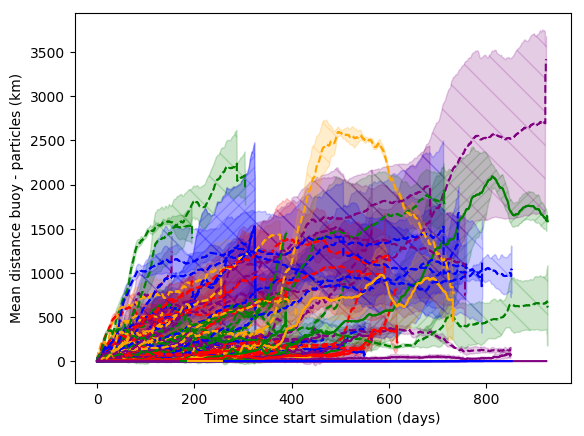

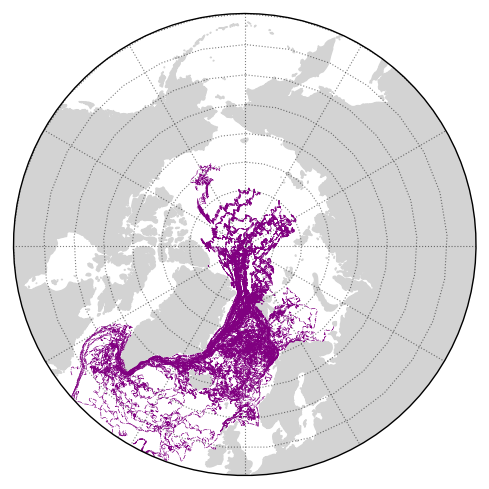

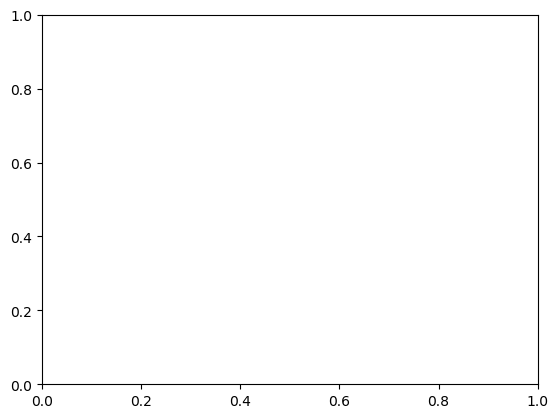

In [10]:
def make_distance_plots_parcels_div(drifter_ids, name='', fig_save=False, method='median', plot_map_drift=True, kernels='both'):
    start = timer()


    fig_distances = plt.figure()
    ax_dist       = fig_distances.add_subplot(1,1,1)
    count = 0
    X     = [0]
    non_existing = []

    ndrifters = len(drifter_ids)
    len_obs   = 10000

    new_means = np.zeros([ndrifters,len_obs])
    old_means = np.zeros([ndrifters,len_obs])
    new_means[:] = np.nan
    old_means[:] = np.nan
    XX    = np.zeros(len_obs)
    XX[:] = np.nan
    
    if kernels == 'both':
        sic_label = "sic"
    else:
        sic_label = ""
    
    if plot_map_drift:
        fig           = plt.figure(figsize = [6,6])
        ax            = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo())
        ax            = set_ax(ax, lat_extent=[50,90])

    for drifter in drifter_ids:
        try:

            b_ind = np.squeeze(np.where(df['buoy_id'] == drifter))

            f_d21_new = glob.glob('/scratch/AnnekeV/output/drifters/all/june26/*drifter{}_*new*npart_5*'.format(drifter))
            f_d21_old = glob.glob('/scratch/AnnekeV/output/drifters/all/june26/*drifter{}_*old*npart_5*'.format(drifter))

            if not f_d21_new:
                non_existing.append(drifter)
                continue
            if len(f_d21_new) > 1: print("{} new has multiple files".format(drifter))
            if len(f_d21_old) > 1: print("{} old has multiple files".format(drifter))
    #         if len(f_d21_new) > 1: print("{} new has multiple files".format(drifter))
    #         if len(f_d21_old) > 1: print("{} old has multiple files".format(drifter))
    #         if len(f_d21_new) < 1: continue
    #         if len(f_d21_old) < 1: continue
            f_d21_new = f_d21_new[0]     
            f_d21_old = f_d21_old[0]     


            ds_new = xr.open_dataset(f_d21_new, decode_times=False)
            ds_new = real_time(ds_new)
            npart  = np.size(ds_new.lat,0)

            ds_old = xr.open_dataset(f_d21_old, decode_times=False)
            ds_old = real_time(ds_old)
            npart  == np.size(ds_old.lat,0)

            time = ds_new.real_time
            lats = ds_new.lat
            ref_path = ds_new.isel(traj=2)


            '''Plot the map'''
            if plot_map_drift:
                for i in range(npart):
                    '''Plot the map with the different drifters on it'''
                    if kernels == 'both':
                        ax.plot(ds_new['lon'][i], ds_new['lat'][i], transform=ccrs.Geodetic(), label ='parcels, sig, {}'.format(i), linewidth=.5, color = 'green')
                    ax.plot(ds_old['lon'][i], ds_old['lat'][i],'-.', transform=ccrs.Geodetic(), label =sic_label, linewidth=.5, color = 'purple')

            dists_new    = np.zeros([npart, len(ref_path.lat)])
            dists_new[:] = np.nan
            dists_old    = np.zeros([npart, len(ref_path.lat)])
            dists_old[:] = np.nan

            x =  (ref_path.real_time.values - ref_path.real_time.values[0]).astype('timedelta64[s]')                                                             
            day = 86400.

            for i in [0, 1, 3, 4]:
                difference_intial_date = ds_new.isel(traj=i).real_time.isel(obs=0).values - ref_path.real_time.values[0]
                indices                = np.searchsorted(ds_new.isel(traj=i).real_time.values,   ref_path.real_time.values+difference_intial_date)

                '''Make sure indices match in length'''
                while (indices[-1] >= len(ds_new.lat.isel(traj=0))) or (indices[-1] >= len(dists_new)):
                    if len(indices)==1: continue
                    indices  = indices[:-1]
                indices-=1
                nlen      = len(indices)

                traj_n  = ds_new.isel(traj=i)
                dist_n = great_circle(ref_path.lon.values, ref_path.lat.values, traj_n.lon.values, traj_n.lat.values)/1000

                traj_o    = ds_old.isel(traj=i)
                dist_o    =  great_circle(ref_path.lon.values, ref_path.lat.values, traj_o.lon.values, traj_o.lat.values)/1000

                dists_new[i, indices] =  dist_n 
                dists_old[i, indices] =  dist_o 


            mean_n = np.nanmean(dists_new, axis=0)
            mean_o = np.nanmean(dists_old, axis=0)


            new_means[count, :len(mean_n)] = mean_n
            old_means[count, :len(mean_n)] = mean_o

            std_n  = np.nanstd(dists_new, axis=0)
            std_o  = np.nanstd(dists_old, axis=0)


            ax_dist.plot(x/day, mean_n, color=colors[count])
            ax_dist.plot(x/day, mean_o, '--', color=colors[count])


            if len(x) > len(X): X = x
            nobs  = len(x)
            '''std'''
            ax_dist.fill_between(x.astype(int)/day, mean_n-std_n, mean_n+std_n,  color=colors[count], alpha=0.2, hatch = '///')
            ax_dist.fill_between(x.astype(int)/day, mean_o-std_o, mean_o+std_o,  color=colors[count], alpha=0.2, hatch = '\\')


            ax_dist.set_xlabel("Time since start simulation (days)")
            ax_dist.set_ylabel("Mean distance buoy - particles (km)")

            if new_means.max() <10: print drifter

            count+=1
        except:
            non_existing.append(drifter)

    print("{} non-existing drifters".format(len(non_existing)))



    '''combined drifter mean'''
    XX[:len(X)] = X/day
    fig_mean = plt.figure()
    ax_mean  = fig_mean.add_subplot(1,1,1)
#     ax_dist.set_ylim([0,50])
    
    
   
    if method == 'mean':
        comb_mean_n = np.nanmean(new_means, axis=0)
        comb_std_n  = np.nanstd(new_means, axis=0)
        low_lim_n, upp_lim_n   = comb_mean_n - comb_std_n, comb_mean_n + comb_std_n
        comb_mean_o = np.nanmean(old_means, axis=0)
        comb_std_o  = np.nanstd(old_means, axis=0)
        low_lim_o, upp_lim_o   = comb_mean_o - comb_std_o, comb_mean_o + comb_std_o
    elif method =='median':
        comb_mean_n = np.nanmedian(new_means, axis=0)
        low_lim_n   = np.nanpercentile(new_means, q=17, axis=0)
        upp_lim_n   = np.nanpercentile(new_means, q=83, axis=0)
        comb_mean_o = np.nanmedian(old_means, axis=0)
        low_lim_o   = np.nanpercentile(old_means, q=17, axis=0)
        upp_lim_o   = np.nanpercentile(old_means, q=83, axis=0)
    else:
        print "Use a proper method"
        return 0
    
    if kernels == 'both':
        ax_mean.plot(XX, comb_mean_n, label='sig-dependent kernel', color = 'red',zorder=2)
        ax_mean.fill_between(XX.astype(int),  low_lim_n, upp_lim_n , alpha=0.1,  color = 'red',edgecolor='None',zorder=1)
    ax_mean.plot(XX, comb_mean_o, '--', label=sic_label, color='purple',zorder=2)
    ax_mean.fill_between(XX.astype(int), low_lim_o, upp_lim_o , alpha=0.1, color = 'purple',edgecolor='None',zorder=1)
     
    
    ax_mean.set_title(name)
    ax_mean.legend()
    ax_mean.set_xlabel("Time since start simulation (days)")
    ax_mean.set_ylabel("Distance between virtual trajectories (km)")
    plt.xlim([0,120])
    plt.ylim([0,ylim])
    ax.set_title("{} drifters".format(count))


    if fig_save:
        fig_mean.savefig("figures/distance_buoy_parcels/within_traj/within_traj_{}_of_mean_region_{}_ndrift_{}_kernels_{}.png".format(method, name, count, kernels))
        fig.savefig("figures/distance_buoy_parcels/within_traj/within_traj_{}_map_region_{}_ndrift_{}_kernels_{}.png".format(method, name, count, kernels))
        fig_distances.savefig("figures/distance_buoy_parcels/within_traj/within_traj_{}_seperate_distances_region_{}_ndrift_{}_kernels_{}.png".format(method, name, count, kernels))
        

    print("{:.0f} s".format(timer()-start))

# make_distance_plots_parcels_div(bid_fram, "Fram", fig_save=True, kernels='old')
plt.show()
make_distance_plots_parcels_div(bid_beau, "Beaufort", fig_save=True, kernels='old')


## scratch book 

8
9
15


/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice


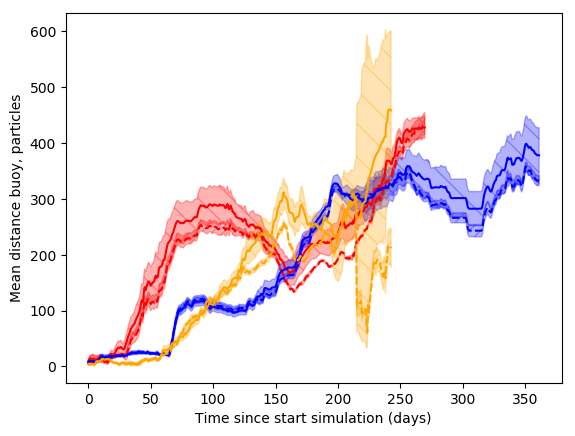

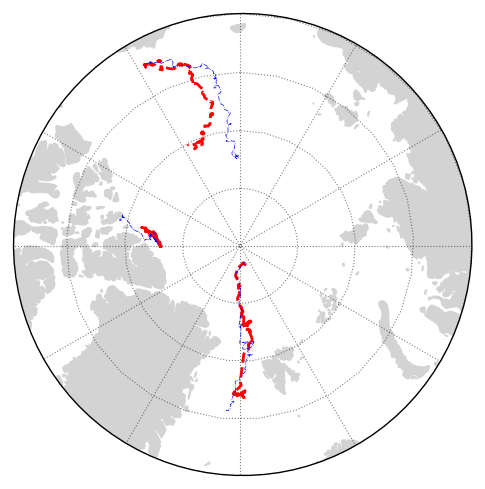

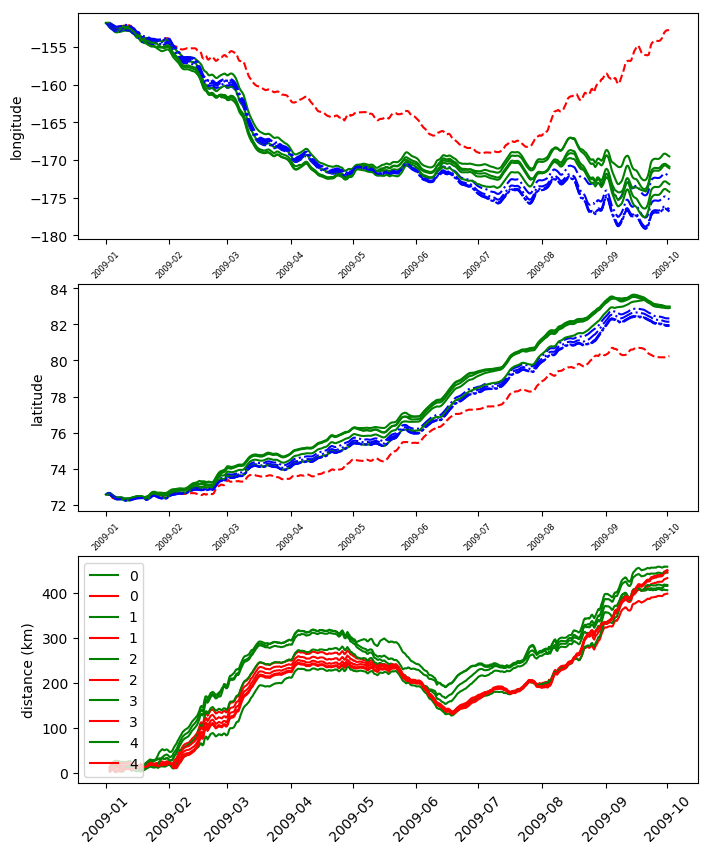

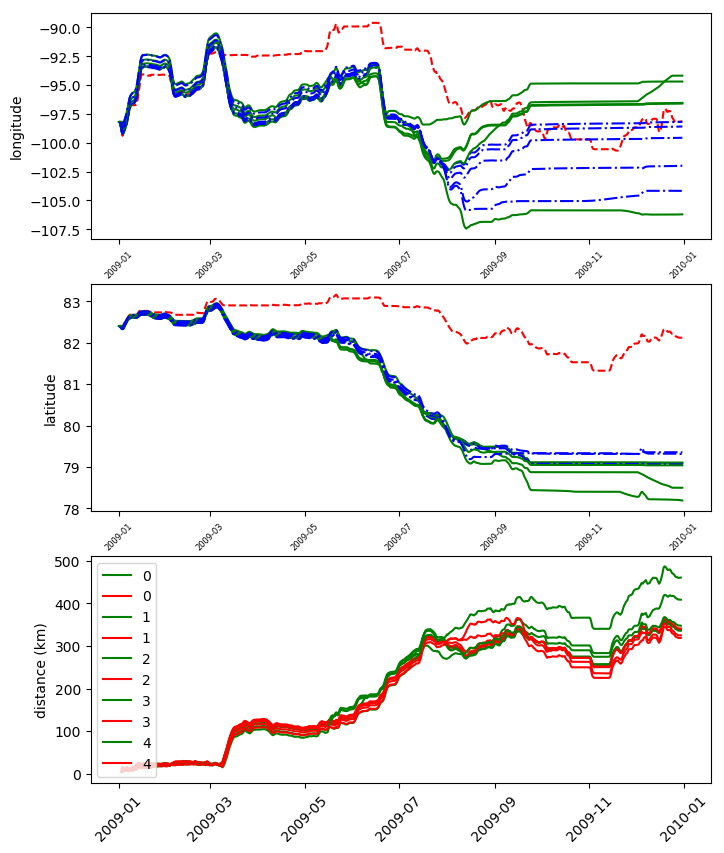

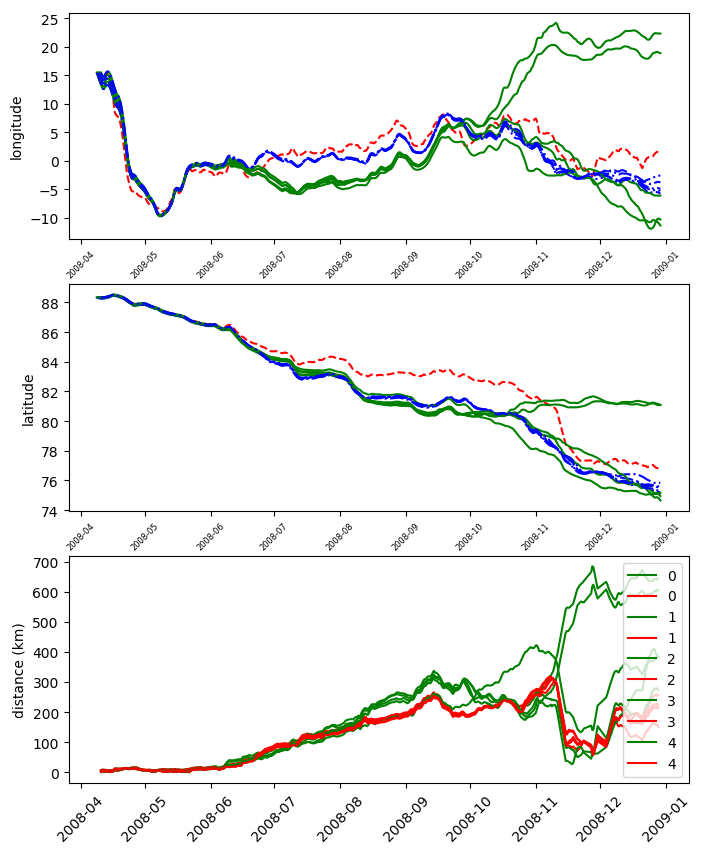

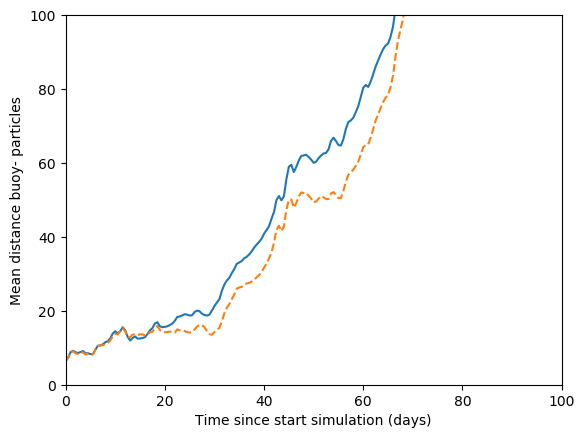

In [18]:
fig_distances = plt.figure()
ax_dist       = fig_distances.add_subplot(1,1,1)
count = 0


new_means = np.zeros([9,1000])
old_means = np.zeros([9,1000])

new_means[:] = np.nan
old_means[:] = np.nan


fig =plt.figure(figsize = [6,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo())
ax = set_ax(ax, lat_extent=[70,90])
for drifter in unique_init:
    print drifter
    b_ind = np.squeeze(np.where(df['buoy_id'] == drifter))


    buoy_21 =  df.iloc[b_ind]
    buoy_21 =  buoy_21.sort_values(by=['year', 'month', 'day', 'hour'], ascending=True)


    f_d21_new = glob.glob('/scratch/AnnekeV/output/drifters/all/06-14*drifter{}_*new*npart_5*'.format(drifter))[0]
    f_d21_old = glob.glob('/scratch/AnnekeV/output/drifters/all/06-14*drifter{}_*old*npart_5*'.format(drifter))[0]

    ds_new = xr.open_dataset(f_d21_new, decode_times=False)
    ds_new = real_time(ds_new)
    npart  = np.size(ds_new.lat,0)

    ds_old = xr.open_dataset(f_d21_old, decode_times=False)
    ds_old = real_time(ds_old)
    npart  == np.size(ds_old.lat,0)

    time = ds_new.real_time
    lats = ds_new.lat
#     for i in range(npart):
#         plt.plot(time[i],lats[i], label = 'parcels new {}'.format(i), linewidth=1)
#         plt.plot(ds_old.real_time[i],ds_old.lat[i], '-.' , label = 'parcels old {}'.format(i), linewidth=1)
#     plt.plot(buoy_21.dates, buoy_21.lat, '--', label = 'buoy', linewidth = 2)
#     plt.xticks(rotation=45)
#     plt.legend(bbox_to_anchor=[1,1])


    fig2  = plt.figure(figsize = [8,10])
    ax21  = fig2.add_subplot(3,1,1)
    ax22  = fig2.add_subplot(3,1,2, sharex=ax21)
    ax23  = fig2.add_subplot(3,1,3, sharex=ax21)

    ax.plot(buoy_21['lon'], buoy_21['lat'], '--', transform=ccrs.Geodetic(), label="buoy 21",  linewidth=2, color='red')
    for i in [3]:
#         ax.plot(ds_new['lon'][i], ds_new['lat'][i], transform=ccrs.Geodetic(), label ='parcels, new_kernel, {}'.format(i), linewidth=.5, color = 'green')
        ax.plot(ds_old['lon'][i], ds_old['lat'][i],'-.',
                transform=ccrs.Geodetic(), linewidth=.5, color = 'blue')

#     ax.legend(bbox_to_anchor=[1,1])


    ax21.plot(buoy_21['dates'].values, buoy_21['lon'].values, '--', label="buoy 21", color='red')
    ax22.plot(buoy_21['dates'].values, buoy_21['lat'].values, '--', label="buoy 21", color='red')
    ax21.set_ylabel("longitude")
    ax22.set_ylabel("latitude")

    for i in range(npart):
        ax21.plot(ds_new['real_time'].values[i], ds_new['lon'][i], label="parcels new {}".format(i), color='green')
        ax22.plot(ds_new['real_time'].values[i], ds_new['lat'][i], label="parcels new {}".format(i), color='green')

        ax21.plot(ds_old['real_time'].values[i], ds_old['lon'][i], '-.', label="parcels old {}".format(i), color ='blue')
        ax22.plot(ds_old['real_time'].values[i], ds_old['lat'][i], '-.', label="parcels old {}".format(i), color='blue')

    
    dists_new = []
    dists_old = []
    for i in range(npart):
        dist_new     = dist(buoy_21[2:-2], ds_new.isel(traj=i))
        dists_new.append( dist_new.values )
        ax23.plot(buoy_21['dates'][2:-2], dist_new, label = "{}".format(i), color='green')

        dist_old     = dist(buoy_21[2:-2], ds_old.isel(traj=i))
        dists_old.append( dist_old.values )
        ax23.plot(buoy_21['dates'][2:-2], dist_old, label = "{}".format(i), color='red')
        
    
    ax23.legend()
    ax23.set_ylabel("distance (km)")
    ax23.tick_params(axis='x', rotation=45, labelsize=10)
    ax21.tick_params(axis='x', rotation=45, labelsize=6)
    ax22.tick_params(axis='x', rotation=45, labelsize=6)

    fig.subplots_adjust(hspace=.3)
    # ax23.set_xlim([buoy_21['dates'].values[0], buoy_21['dates'].values[5]])
    # ax21.set_ylim([-142,-144])
    
    def mean_dist(dist_list):
        return np.nanmean(np.array(dist_list), axis = 0)
    def std_dist(dist_list):
        return np.nanstd(np.array(dist_list), axis = 0)
    def fill_std(x, dist_list):
        mean = mean_dist(dist_list)
        std  = std_dist(dist_list)
        y1   = mean-std
        y2   = mean+std
        return y1, y2


    ndatepoints= len(buoy_21['dates'][2:-2])   # note every 12 hours
    x          = np.arange(ndatepoints)/2.
    
    '''means'''
    ax_dist.plot(x, mean_dist(dists_new), label = "{} n".format(drifter), color=colors[count])
    ax_dist.plot(x, mean_dist(dists_old), '--', label = "{} o".format(drifter), color=colors[count])
    new_means[count,:ndatepoints] =mean_dist(dists_new)
    old_means[count, :ndatepoints] = mean_dist(dists_old)
    
    '''std'''
    y1, y2 = fill_std(x, dists_new)
    ax_dist.fill_between(x, y1, y2,  color=colors[count], alpha=0.3, hatch = '\\')
    y1, y2 = fill_std(x, dists_old)
    ax_dist.fill_between(x, y1, y2,  color=colors[count], alpha=0.3, hatch = '///')

    

    count+=1
    if count == 3: break
    
# ax_dist.legend()
ax_dist.set_xlabel("Time since start simulation (days)")
ax_dist.set_ylabel("Mean distance buoy, particles")
# fig_distances.savefig("figures/drifter/mean_old_new_per_run.png")

plt.figure()
plt.plot(np.arange(1000)/2., mean_dist(new_means), label='new')
plt.plot(np.arange(1000)/2., mean_dist(old_means), '--', label='old')
# plt.legend()
plt.xlabel("Time since start simulation (days)")
plt.ylabel("Mean distance buoy- particles")
plt.xlim([0,100])
plt.ylim([0,100])

fig.savefig("figures/drifter/mean_old_vs_new_mean_zoom.png")


In [34]:
np.nanmean(np.array(dists_old), axis=0)
mean_dist(dists_old)

array([        nan,  1.97315639,  4.88418326, 10.46261579, 10.8931793 ,
       13.09413244, 14.48101328, 15.11109716, 16.61648166])

In [ ]:
ds_new.isel(traj=i)

In [ ]:
ds_new.time

In [ ]:
buoy_21

In [ ]:
buoy_21[2:-2]